In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from models.cnn_quickdraw import CNNQuickDraw

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
from torch.utils.data import TensorDataset

with open("data/label_dict.pkl", 'rb') as f:
    label_dict = pickle.load(f)

X_train = torch.from_numpy(np.load("data/X_train.npy"))
y_train = torch.from_numpy(np.load("data/y_train.npy")).long()
X_test  = torch.from_numpy(np.load("data/X_test.npy" ))
y_test  = torch.from_numpy(np.load("data/y_test.npy" )).long()

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [21]:
def compute_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    
    accuracy = float(num_correct)/float(num_samples)*100
    return accuracy
    
train_accuracy_values = []
test_accuracy_values = []

In [ ]:
from torch.utils.data import DataLoader

# Hyper-parameters 
num_epochs = 50
batch_size = 256
learning_rate = 0.001
momentum = 0.9

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = CNNQuickDraw(num_classes=len(label_dict)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

total_iterations = len(train_loader) * num_epochs

pbar = tqdm(total=total_iterations, desc="Training Progress", position=0)
model.train()
for epoch in range(num_epochs):
    pbar.set_postfix(epoch=f"[{epoch + 1}/{num_epochs}]")
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Update progress bar
        pbar.update()
        
    # Evaluate model
    train_accuracy = compute_accuracy(loader=train_loader, model=model)
    test_accuracy = compute_accuracy(loader=test_loader, model=model)
    
    train_accuracy_values.append(train_accuracy)
    test_accuracy_values.append(test_accuracy)

pbar.close()

Training Progress: 100%|██████████| 584300/584300 [1:07:40<00:00, 143.89it/s, epoch=[50/50]] 


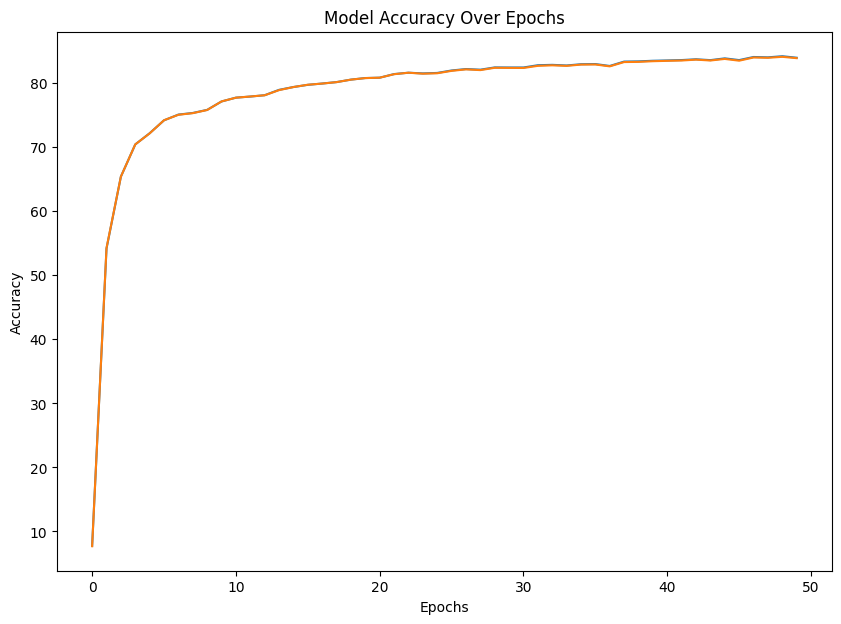

In [23]:
plt.figure(figsize=(10,7))
plt.title("Model Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.plot(range(len(train_accuracy_values)), train_accuracy_values)
plt.plot(range(len(test_accuracy_values)), test_accuracy_values)

In [ ]:
model.to("cpu")
torch.save(model.state_dict(), "models/cnn_quickdraw.pt")